<a href="https://colab.research.google.com/github/sv9-ru/25-koptyaev-TimeSeriesCourse/blob/main/01_Basics(do1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Анализ и прогнозирование временных рядов методами искусственного интеллекта

## **Практическая работа 1. Метрики и меры схожести между временными рядами.**

Смените рабочую директорию с помощью команды `chdir()`. Для этого передайте этой команде свой путь до каталога, в котором содержатся материалы первой практической работы. После выполнения этой команды все последующие операции с файлами и каталогами будут производиться относительно указанного каталога.

##п

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.listdir('/content/drive/My Drive/MASHINKA/01 Basics')

['01 Basics.ipynb', 'datasets', 'modules', 'img']

In [3]:
import os

practice_dir_path = '/content/drive/My Drive/MASHINKA/01 Basics'
os.chdir(practice_dir_path)

Выполните команды, которые автоматически перезагружают все импортированные модули при их изменении.

In [4]:
#%load_ext autoreload
#%autoreload 2

Импортируйте библиотеки и модули, необходимые для реализации практической работы 1.

In [5]:
!pip install sktime

In [6]:
import numpy as np
import random
from sktime.distances import euclidean_distance, dtw_distance, pairwise_distance
from sklearn.metrics import silhouette_score
import cv2
import imutils
import glob
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

from modules.metrics import ED_distance, norm_ED_distance, DTW_distance
from modules.pairwise_distance import PairwiseDistance
from modules.clustering import TimeSeriesHierarchicalClustering
from modules.classification import TimeSeriesKNN, calculate_accuracy
from modules.image_converter import Image2TimeSeries
from modules.utils import read_ts, z_normalize, sliding_window, random_walk
from modules.plots import plot_ts

## **Часть 1.** Функции расстояния: евклидова метрика и DTW мера. Матрица расстояний. Иерархическая кластеризация временных рядов.

### **Задача 1.**
Реализуйте самостоятельно функцию `ED_distance()` в модуле *metrics.py*, которая вычисляет евклидово расстояние между двумя временными рядами, имеющими одинаковую длину. В качестве входных данных передайте в функцию два синтетических временных ряда некоторой заданной вами длины. Для их генерации используйте функцию `random_walk()` из модуля *utils.py*,  реализующую модель случайных блужданий (Random Walk), или стандартный модуль *random*.

**Евклидово расстояние** между двумя временными рядами $T_1$ и $T_2$ длины $n$ вычисляется следующим образом:

\begin{equation}
    \text{ED}(T_1, T_2) = \sqrt{\sum_{i=1}^{n} ({t_{1}}_i-{t_{2}}_i)^2}.
\end{equation}

Проверьте реализацию функции, сравнив свои результаты с результатами функции [`euclidean_distance()`](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.distances.euclidean_distance.html) из библиотеки *sktime*, с помощью `test_distances()`.

In [7]:
def test_distances(dist1: float, dist2: float) -> None:
    """
    Check whether your distance function is implemented correctly

    Parameters
    ----------
    dist1 : distance between two time series calculated by sktime
    dist2 : distance between two time series calculated by your function
    """

    np.testing.assert_equal(round(dist1, 5), round(dist2, 5), 'Distances are not equal')

In [8]:
import numpy as np
from modules.utils import random_walk  # Импортируй из твоего модуля
from modules.metrics import ED_distance
from sktime.distances import euclidean_distance

# Генерация двух синтетических рядов
n = 100  # Длина ряда
ts1 = random_walk(n)
ts2 = random_walk(n)

print("TS1:", ts1)
print("TS2:", ts2)

from modules.metrics import ED_distance  # После реализации
from sktime.distances import euclidean_distance  # Если sktime установлен; иначе используй np.linalg.norm(ts1 - ts2)

# Вычисление расстояний
dist_mine = ED_distance(ts1, ts2)
dist_sktime = euclidean_distance(ts1, ts2)

print(f"Моё расстояние: {dist_mine}")
print(f"Sktime расстояние: {dist_sktime}")

# Тест
def test_distances(dist1: float, dist2: float) -> None:
    np.testing.assert_equal(round(dist1, 5), round(dist2, 5), 'Distances are not equal')

test_distances(dist_sktime, dist_mine)
print("Тест пройден!")

TS1: [ 0  1  0  1  0  1  0  1  2  3  2  1  0  1  0 -1 -2 -3 -2 -1  0  1  2  3
  4  3  2  1  2  3  4  5  6  5  6  5  6  7  8  9 10  9  8  7  6  5  6  5
  4  3  2  3  4  5  4  5  4  5  6  5  6  5  4  5  4  3  4  3  2  3  4  5
  4  3  4  3  2  3  2  3  2  3  2  3  2  1  0 -1 -2 -3 -2 -1  0  1  2  1
  0  1  0  1]
TS2: [ 0 -1 -2 -1 -2 -3 -4 -3 -4 -3 -2 -3 -4 -3 -4 -5 -4 -3 -2 -1 -2 -3 -2 -3
 -4 -5 -4 -3 -4 -5 -6 -7 -6 -5 -4 -5 -6 -7 -6 -5 -4 -5 -4 -3 -4 -3 -4 -5
 -4 -3 -2 -3 -2 -1  0  1  2  1  0  1  2  1  2  1  0  1  0 -1 -2 -3 -2 -3
 -4 -5 -6 -5 -6 -5 -6 -7 -6 -5 -6 -7 -6 -5 -4 -3 -2 -3 -2 -1  0 -1 -2 -3
 -2 -1 -2 -3]
Моё расстояние: 68.20557161991974
Sktime расстояние: 68.20557161991974
Тест пройден!


### **Задача 2.**

Реализуйте самостоятельно функцию `DTW_distance()` в модуле *metrics.py*, которая вычисляет DTW расстояние между двумя временными рядами, имеющими одинаковую длину. Для вычисления расстояния между элементами временных рядов в DTW мере используйте евклидово расстояние. Временные ряды сгенерируйте аналогичным образом, как в задаче 1, или используйте уже созданные.

**Динамическая трансформация временной шкалы (Dynamic Time Warping, DTW)** – мера схожести между двумя временными рядами $T_1$ и $T_2$ длины $n$, вычисляемая следующим образом:

\begin{equation}
\text{DTW}(T_1, T_2) = d(n,n),
\\ d(i,j) = ({t_{1}}_i - {t_{2}}_j)^2 + \min \left\{
	\begin{array}{l l}
	d(i-1,j), \\
	d(i,j-1), \\
	d(i-1,j-1),
	\end{array}
	\right.
\\ d(0,0)=0, \quad d(i,0)=d(0,j)=\infty, \quad  1 \leqslant i,j \leqslant n.
\end{equation}

Сравните свои результаты с результатами функции [`dtw_distance()`](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.distances.dtw_distance.html) из библиотеки *sktime*. Для этого используйте `test_distances()` из задачи 1.

In [9]:
import numpy as np
from modules.utils import random_walk
from modules.metrics import DTW_distance
from sktime.distances import dtw_distance

# Генерация синтетических рядов (или используем старые)
n = 100
ts1 = random_walk(n)
ts2 = random_walk(n)

# Вычисление расстояний
dist_mine = DTW_distance(ts1, ts2, r=1.0)  # Укажем r как float для консистентности
dist_sktime = dtw_distance(ts1, ts2, window=1.0)  # Исправлено: window=1.0

print(f"Моё DTW расстояние: {dist_mine}")
print(f"Sktime DTW расстояние: {dist_sktime}")

# Тест из задачи
def test_distances(dist1: float, dist2: float) -> None:
    np.testing.assert_equal(round(dist1, 5), round(dist2, 5), 'Distances are not equal')

test_distances(dist_sktime, dist_mine)
print("Тест пройден!")

Моё DTW расстояние: 52438.0
Sktime DTW расстояние: 52438.0
Тест пройден!


### **Задача 3.**
Реализуйте нахождение матрицы расстояний между несколькими временными рядами.
Для этого заполните все методы c недостающим кодом в классе `PairwiseDistance` из модуля *pairwise_distance.py*. Для вычисления расстояний между рядами используйте ранее реализованные вами функции `ED_distance()` и `DTW_distance()` из модуля *metrics.py*.

Матрица расстояний между временными рядами определяется следующим образом. Пусть дано множество $S$, состоящее из $K$ временных рядов длины $n$: $\;S = \{T_1, T_2, ..., T_K\}, \; T_i \in \mathbb{R}^n$. Тогда под **матрицей расстояний** $D \in \mathbb{R}^{K \times K}$ понимается квадратная матрица, где каждый ее элемент $d(i,j)$ представляет собой расстояние между временными рядами $T_i$ и $T_j$ из множества $S$:
\begin{equation}
d(i,j) = dist(T_i, T_j), \quad T_i, T_j \in S, \quad 1 \leqslant i,j \leqslant K.
\end{equation}

Поскольку евклидова метрика и DTW мера удовлетворяют аксиоме симметричности (т.е. $dist(T_i, T_j)=dist(T_j, T_i)$), то матрица расстояний $D$ будет симметричной относительно главной диагонали. Для ускорения вычислений достаточно найти ее верхний треугольник, а нижний треугольник матрицы заполнить значениями верхнего треугольника следующим образом:
\begin{equation}
d(j,i) = d(i,j), \; где \; i < j.
\end{equation}

<center><img src="https://github.com/mzym/TimeSeriesCourse/blob/main/practice/01%20Basics/img/distance_matrix.png?raw=true" width="600"></center>

Сгенерируйте множество, состоящее из $K$ временных рядов некоторой длины $n$. Вычислите матрицы евклидовых и DTW расстояний между ними. Проверьте реализованные вами методы, сравнив свои результаты с результатами функции [`pairwise_distance()`](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.distances.pairwise_distance.html) из библиотеки *sktime*.

In [10]:
def test_matrices(matrix1 : np.ndarray, matrix2 : np.ndarray) -> None:
    """
    Check whether your matrix function is implemented correctly

    Parameters
    ----------
    matrix1 : distance matrix calculated by sktime
    matrix2 : distance matrix calculated by your function
    """

    np.testing.assert_equal(matrix1.round(5), matrix2.round(5), 'Matrices are not equal')

In [11]:
import numpy as np
from modules.utils import random_walk
from modules.pairwise_distance import PairwiseDistance
from sktime.distances import pairwise_distance

# Генерация множества временных рядов
K = 5  # Количество рядов
n = 100  # Длина каждого ряда
input_data = np.array([random_walk(n) for _ in range(K)])

# Матрица евклидовых расстояний
ed_dist = PairwiseDistance(metric='euclidean', is_normalize=False)
my_ed_matrix = ed_dist.calculate(input_data)
sktime_ed_matrix = pairwise_distance(input_data, metric='euclidean')

# Матрица DTW расстояний
dtw_dist = PairwiseDistance(metric='dtw', is_normalize=False)
my_dtw_matrix = dtw_dist.calculate(input_data)
sktime_dtw_matrix = pairwise_distance(input_data, metric='dtw', window=1.0)

print("Моя матрица ED:\n", my_ed_matrix.round(5))
print("Sktime матрица ED:\n", sktime_ed_matrix.round(5))
print("Моя матрица DTW:\n", my_dtw_matrix.round(5))
print("Sktime матрица DTW:\n", sktime_dtw_matrix.round(5))

# Тест
def test_matrices(matrix1: np.ndarray, matrix2: np.ndarray) -> None:
    np.testing.assert_equal(matrix1.round(5), matrix2.round(5), 'Matrices are not equal')

test_matrices(sktime_ed_matrix, my_ed_matrix)
test_matrices(sktime_dtw_matrix, my_dtw_matrix)
print("Тесты пройдены!")

Моя матрица ED:
 [[  0.      104.38391  56.49779  54.22177 113.03097]
 [104.38391   0.       66.99254  86.18585  36.66061]
 [ 56.49779  66.99254   0.       36.93237  71.04928]
 [ 54.22177  86.18585  36.93237   0.       96.43651]
 [113.03097  36.66061  71.04928  96.43651   0.     ]]
Sktime матрица ED:
 [[  0.      104.38391  56.49779  54.22177 113.03097]
 [104.38391   0.       66.99254  86.18585  36.66061]
 [ 56.49779  66.99254   0.       36.93237  71.04928]
 [ 54.22177  86.18585  36.93237   0.       96.43651]
 [113.03097  36.66061  71.04928  96.43651   0.     ]]
Моя матрица DTW:
 [[   0. 9688.  412.  418. 7964.]
 [9688.    0. 3738. 6870.  316.]
 [ 412. 3738.    0.   72. 2126.]
 [ 418. 6870.   72.    0. 3710.]
 [7964.  316. 2126. 3710.    0.]]
Sktime матрица DTW:
 [[   0. 9688.  412.  418. 7964.]
 [9688.    0. 3738. 6870.  316.]
 [ 412. 3738.    0.   72. 2126.]
 [ 418. 6870.   72.    0. 3710.]
 [7964.  316. 2126. 3710.    0.]]
Тесты пройдены!


### **Задача 4.**
Далее рассмотрим задачу иерархической кластеризации временных рядов, где будет использоваться предвычисленная матрица расстояний.

Для этого сначала загрузите набор временных рядов CBF из файла *CBF_TRAIN.txt*, который располагается в директории *./datasets/part1*. Каждая строка данного файла содержит целевую переменную (класс: 0, 1 или 2) в первом столбце и временной ряд в остальных столбцах. Набор CBF является синтетическим и включает в себя 30 временных рядов,  каждый из которых принадлежит к одному из трех классов.

In [12]:
url = '/content/drive/MyDrive/MASHINKA/01 Basics/datasets/part1/CBF_TRAIN.txt'

data = read_ts(url)

ts_set = data[:, 1:]
labels = data[:, 0].astype(int)

/content/drive/MyDrive/MASHINKA/01 Basics/modules/utils.py:20: FutureWarning:

The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead



Выполните визуализацию по одному временному ряду из каждого класса. Для этого используйте функцию `plot_ts()` из модуля *plots.py*.

In [13]:
unique_labels = np.unique(labels)
representatives = []
reprentative_labels = []

for label in unique_labels:
  idx = np.where(labels == label)[0][0]
  representatives.append(ts_set[idx])
representatives_np = np.array(representatives)
plot_ts(representatives_np, 'title')

Далее самостоятельно реализуйте класс `TimeSeriesHierarchicalClustering` из модуля *clustering.py*, который выполняет иерархическую кластеризацию временных рядов.

Перед тем как приступить к реализации, изучите скелет этого класса. Реализуйте метод `fit()`, выполняющий кластеризацию данных на основе предвычисленной матрицы расстояний, которая передается в данный метод. Поскольку реализовать иерархическую кластеризацию довольно сложно, используйте готовую реализацию [`AgglomerativeClustering`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html) из *sklearn*.   

Выполните иерархическую кластеризацию загруженных временных рядов CBF для двух функций расстояния: евлидовой метрики и DTW меры.
Для этого сначала найдите матрицы расстояний между временными рядами, используя класс `PairwiseDistance`, и передайте каждую матрицу в метод `fit()` для кластеризации.
Далее выполните визуализацию результатов в виде дендрограмм с помощью метода `plot_dendrogram()`, передав исходный набор временных рядов и их метки.

Форма ts_set: (30, 128)
Форма ED матрицы: (30, 30)
Форма DTW матрицы: (30, 30)


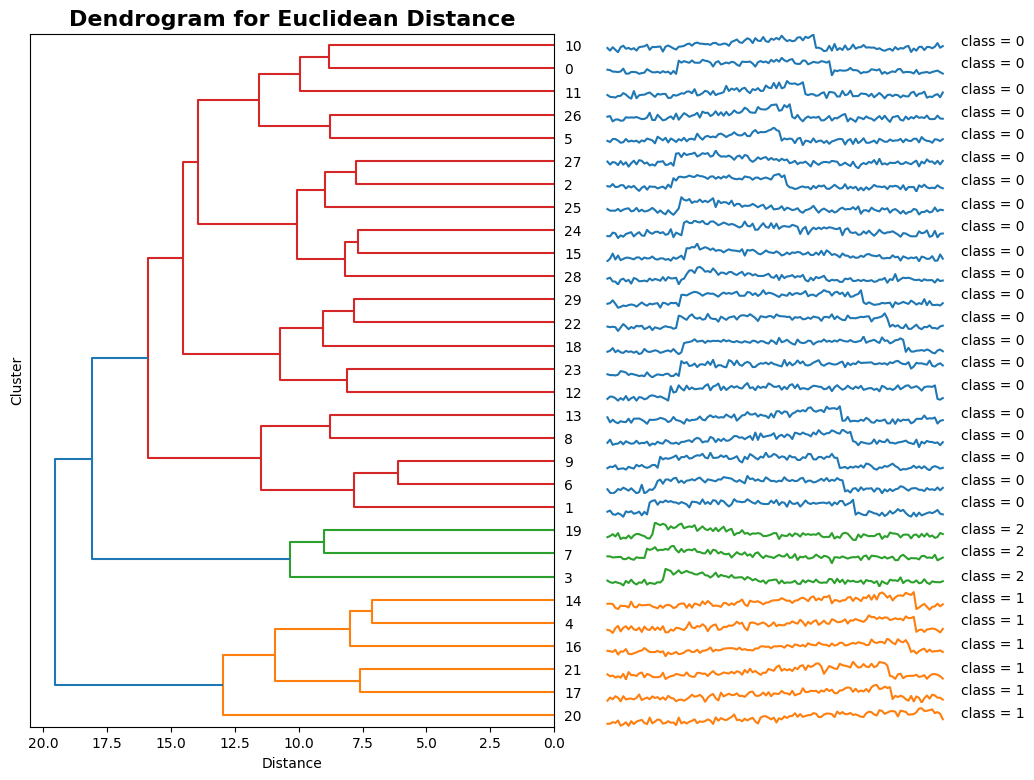

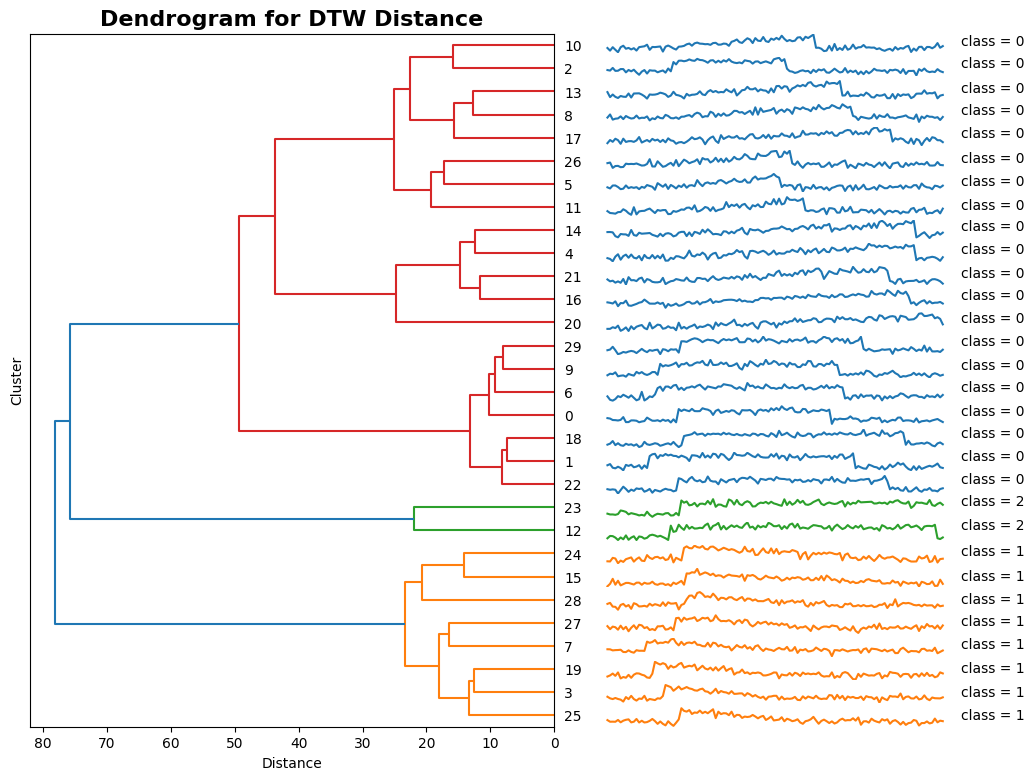

In [26]:
import pandas as pd
import numpy as np
from modules.pairwise_distance import PairwiseDistance
from modules.clustering import TimeSeriesHierarchicalClustering
from modules.plots import plot_ts  # Опционально для визуализации


file_path = '/content/drive/MyDrive/MASHINKA/01 Basics/datasets/part1/CBF_TRAIN.txt'

# Чтение данных
data = pd.read_csv(file_path, header=None, sep=r'\s+')

true_labels = data.iloc[:, 0].values  # Истинные метки
ts_set = data.iloc[:, 1:].values  # Ряды
ts_df = pd.DataFrame(ts_set.T)  # Транспонировано для plot_dendrogram

print(f"Форма ts_set: {ts_set.shape}")

# Матрица евклидовых расстояний
pairwise_ed = PairwiseDistance(metric='euclidean', is_normalize=False)
ed_matrix = pairwise_ed.calculate(ts_set)
print(f"Форма ED матрицы: {ed_matrix.shape}")

# Кластеризация и дендрограмма для ED
h_clustering_ed = TimeSeriesHierarchicalClustering(n_clusters=3, method='complete')
h_clustering_ed.fit(ed_matrix)
h_clustering_ed.plot_dendrogram(ts_df, h_clustering_ed.labels_, title='Dendrogram for Euclidean Distance')

# Матрица DTW расстояний
pairwise_dtw = PairwiseDistance(metric='dtw', is_normalize=False)
dtw_matrix = pairwise_dtw.calculate(ts_set)
print(f"Форма DTW матрицы: {dtw_matrix.shape}")

# Кластеризация и дендрограмма для DTW
h_clustering_dtw = TimeSeriesHierarchicalClustering(n_clusters=3, method='complete')
h_clustering_dtw.fit(dtw_matrix)
h_clustering_dtw.plot_dendrogram(ts_df, h_clustering_dtw.labels_, title='Dendrogram for DTW Distance')

Сравните результаты иерархической кластеризации, полученные при двух различных функций расстояния, с помощью силуэтного коэффициента. Для этого используйте функцию [`silhouette_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) из библиотеки *sklearn*, передав в нее предвычисленную матрицу расстояний и предсказанные метки.

**Силуэтный коэффициент** – метрика, которая оценивает качество кластеризации на основе исходной выборки и результатов кластеризации без необходимости знания об истинных метках объектов.

Силуэтный коэффициент для выборки показывает, насколько среднее расстояние до объектов своего кластера отличается от среднего расстояния до объектов других кластеров. Пусть дана выборка $X$, состоящая из $N$ объектов. Предположим, что объекты этой выборки были разбиты на кластеры $c_1, ... c_K$, $c_i \in C$, с помощью некоторого алгоритма кластеризации. Тогда силуэтный коэффициент для выборки будет вычисляться следующим образом:

\begin{equation}
sil\_coef = \frac{1}{N} \sum_{c_k \in C} \sum_{x_i \in c_k} \frac{b(x_i, c_k) - a(x_i, c_k)}{\max(a(x_i, c_k), b(x_i, c_k))},
\end{equation}

где $a(x_i, c_k)$ – среднее расстояние от объекта $x_i \in c_k$ до других объектов из этого же кластера $c_k$; <br> $b(x_i, c_k)$  – среднее расстояние от объекта $x_i \in c_k$ до объектов из другого кластера $c_l$, $k \neq l$.

Силуэтный коэффициент принимает значения от  −1  до  1:
*   –1 означает, что кластеры плохие, размытые;
*   0 означает, что кластеры накладываются друг на друга;
*   1 означает, что кластеры плотные и хорошо отделены друг от друга.

Таким образом, чем ближе значение коэффициента к 1, тем лучше кластеризованы данные.

In [27]:
from sklearn.metrics import silhouette_score

# Предполагая, что ed_matrix, dtw_matrix, h_clustering_ed, h_clustering_dtw уже вычислены из предыдущего кода

# Силуэтный коэффициент для ED
sil_ed = silhouette_score(ed_matrix, h_clustering_ed.labels_, metric='precomputed')
print(f"Силуэтный коэффициент для Euclidean Distance: {sil_ed}")

# Силуэтный коэффициент для DTW
sil_dtw = silhouette_score(dtw_matrix, h_clustering_dtw.labels_, metric='precomputed')
print(f"Силуэтный коэффициент для DTW: {sil_dtw}")

# Сравнение
if sil_ed > sil_dtw:
    print("Кластеризация с Euclidean Distance лучше (выше силуэтный коэффициент).")
elif sil_dtw > sil_ed:
    print("Кластеризация с DTW лучше (выше силуэтный коэффициент).")
else:
    print("Кластеризации имеют одинаковый силуэтный коэффициент.")

Силуэтный коэффициент для Euclidean Distance: 0.1803917727906887
Силуэтный коэффициент для DTW: 0.3881450644470224
Кластеризация с DTW лучше (выше силуэтный коэффициент).


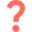
Проанализируйте полученные результаты кластеризации с помощью построенных дендрограмм и вычисленных силуэтных коэффициентов. Какая, на ваш взгляд, функция расстояния показала лучший результат и почему? Укажите, в каких случаях более предпочтительно использовать DTW меру, чем евклидову метрику.

*# WRITE YOUR ANSWER*

## **Часть 2.** $Z$-нормализация временных рядов.

### **Задача 5.**
Реализуйте функцию вычисления нормализованного евклидова расстояния между временными рядами `norm_ED_distance()` в модуле *metrics.py* и проверьте правильность своей реализации, сравнив полученные результаты с результатами функции [`ed_distance()`](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.distances.euclidean_distance.html) из библиотеки *sktime*, в которую необходимо передать <u>нормализованные</u> временные ряды. Для нормализации временных рядов используйте функцию `z-normalize()` из *utils.py*.  Для проверки можно использовать синтетические временные ряды из первой части или заново их сгенерировать.

**Нормализованная евклидова метрика** между двумя временными рядами $T_1$ и $T_2$ длины $n$ вычисляется следующим образом:

\begin{equation}
	\text{ED}_{norm}(T_1, T_2) = \sqrt {\Big|\; 2n\left(1-\dfrac{<T_1, T_2> - \; n \; \cdotp \mu_{T_1} \; \cdotp \mu_{T_2}}{n \; \cdotp \sigma_{T_1} \; \cdotp \sigma_{T_2}}\right)\Big|},
\end{equation}

где $<T_1, T_2>$ – скалярное произведение временных рядов, $\mu_{T_1}$ и $\mu_{T_2}$, $\sigma_{T_1}$ и $\sigma_{T_2}$ – среднее арифметическое и стандартное отклонение временных рядов соответственно.

**Среднее арифметическое** $\mu_T$ и **стандартное отклонение** $\sigma_T$ временного ряда $T$ длины $n$ вычисляются по следующим формулам:

\begin{equation}
	\mu_{T} = \frac{1}{n}\sum\limits_{i=1}^{n} t_{i}, \\[1em]
	\sigma_{T} = \sqrt{\frac{1}{n}\sum\limits_{i=1}^{n} t_i^2-\mu_{T}^2}.
\end{equation}

In [16]:
# INSERT YOUR CODE

### **Задача 6.**
Далее убедимся, что выполнение $z$-нормализации на этапе предобработки данных имеет важное значение и может повысить точность решаемой задачи.

В данном задании вы продолжите решать задачу иерархической кластеризации. В качестве данных будут использоваться два временных ряда из набора данных [BIDMC](https://physionet.org/content/chfdb/1.0.0/). Набор BIDMC состоит из записей ЭКГ-сигналов, снятых с 15 пациентов с сердечной недостаточностью тяжелой степени.  

Загрузите два временных ряда и визуализируйте их с помощью функции `plot_ts()` из модуля *plots.py*.

In [17]:
url1 = './datasets/part2/chf10.csv'
ts1 = read_ts(url1)

url2 = './datasets/part2/chf11.csv'
ts2 = read_ts(url2)

/content/drive/MyDrive/MASHINKA/01 Basics/modules/utils.py:20: FutureWarning:

The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead

/content/drive/MyDrive/MASHINKA/01 Basics/modules/utils.py:20: FutureWarning:

The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead



In [18]:
ts_set = np.concatenate((ts1, ts2), axis=1).T

In [19]:
plot_ts(ts_set)

Разделите каждый временной ряд на непересекающиеся подпоследовательности с помощью техники скользящего окна. Для этого используйте функцию `sliding_window()` из модуля *utils.py*, передав в нее временной ряд, заданную длину подпоследовательности и величину шага. В нашем случае, величина шага равна длине подпоследовательности.

In [20]:
m = 125
subs_set1 = sliding_window(ts_set[0], m, m-1)
subs_set2 = sliding_window(ts_set[1], m, m-1)

Сформируйте множество всех подпоследовательностей, извлеченных из двух временных рядов, и массив меток подпоследовательностей в соответствии с их принадлежностью к временному ряду.

In [21]:
subs_set = np.concatenate((subs_set1[0:15], subs_set2[0:15]))
labels = np.array([0]*subs_set1[0:15].shape[0] + [1]*subs_set2[0:15].shape[0])

Добавьте в класс `PairwiseDistance` из модуля *pairwise_distance.py* возможность вычисления нормализованной евклидовой метрики между временными рядами. Если матрица расстояний строится для нормализованных временных рядов на основе евклидовой метрики, то должна вызываться функция `norm_ED_distance()`. Для остальных метрик/мер схожести перед нахождением матрицы расстояний временные ряды должны подтвергаться $z$-нормализации с помощью функции `z_normalize()` из модуля *utils.py*.

Далее выполните иерархическую кластеризацию подпоследовательностей двух временных рядов с использованием предварительно построенных матриц расстояний на основе классической и нормализованной евклидовой метрики.

In [22]:
# INSERT YOUR CODE

Вычислите силуэтные коэффициенты для оценки качества кластеризации с нормализацией и без нее, как это было сделано в задаче 4 части 1.

In [23]:
# INSERT YOUR CODE

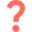
Сравните полученные результаты кластеризации с помощью построенных дендрограмм и вычисленных силуэтных коэффициентов. Позволила ли $z$-нормализации временных рядов повысить качество кластеризации?

*# WRITE YOUR ANSWER*

## **Часть 3.** Классификация изображений, представленных в виде временных рядов.

### **Задача 7.**
В данном задании вам предстоит выполнить преобразование изображения, на котором находится некоторый объект, во временной ряд. Для этого вы реализуете один из существующих методов, предложенный в [статье Кеога и др](https://dl.acm.org/doi/10.5555/1182635.1164203).

Данный метод заключается в том, что сначала на изображении выполняется поиск контура $E = \{e_i\}_{i=1}^L$, где $e_i$ – точки контура, и центра масс объекта $O$. Затем берутся точки, расположенные на контуре объекта, следующим образом.

Рассмотрим луч $OP$ с началом в центре масс объекта $O$, направление которого совпадает с положительным направлением оси Ox (см. рисунок). Далее выполняется поворот против часовой стрелки луча $OP$ вокруг центра масс $O$ на некоторый заданный угол $α$, $1° \leqslant α \leqslant 360°$. Поворот луча будет осуществляться до тех пор, пока луч не пройдет полный оборот. Все точки $P = \{P_i\}_{i=1}^K$, $P_i \in E$, $K = \lfloor \frac{360°}{α} \rfloor$, образованные пересечением луча $OP$ с контуром $E$ во время поворота, будут являться искомыми.

На завершающем шаге метода вычисляются расстояния между центром масс объекта $O$ и найденными точками на контуре $P$. В качестве функции расстояния может быть использовано манхэттенское или евклидово расстояние. Полученные расстояния будут формировать временной ряд $T$ длины $K$:
\begin{equation}
T = \{t_i\}_{i=1}^K,\;где \; t_i = dist(O, P_i), \; P_i \in P.
\end{equation}

\
<center><img src="https://github.com/mzym/TimeSeriesCourse/blob/main/practice/01%20Basics/img/image2ts.png?raw=true" width="1000"></center>

Поскольку часть 3 предполагает работу с изображениями, то вы будете использовать для реализации некоторых частей кода библиотеку компьютерного зрения *cv2*. Для поиска всех необходимых функций рекомендуем воспользоваться [документацией библиотеки cv2](https://docs.opencv.org/4.x/d6/d00/tutorial_py_root.html).

Загрузите изображение *example.tif* из директории *./datasets/part3* и выполните его визуализацию с помощью соответствующих функций из библиотеки *cv2*.

In [24]:
# INSERT YOUR CODE

За конвертацию изображения во временной ряд с помощью описанного выше метода отвечает функция `image2ts()` из модуля *image_converter.py*. Прежде чем исходное изображение будет преобразовано во временной ряд, сначала оно должно пройти этап предварительной обработки. Предварительная обработка включает в себя следующие шаги:

<center><img src="https://github.com/mzym/TimeSeriesCourse/blob/main/practice/01%20Basics/img/image_preprocessing.png?raw=true" width="1000"></center>

Предобработка изображения в `image2ts()` осуществляется с помощью функции `_img_preprocess()`. Реализуйте в данной функции все представленные на диаграмме шаги предварительной обработки средствами библиотеки *cv2*. Промежуточные результаты должны совпадать с представленными на диаграмме.

Далее выполните конвертацию изображения во временной ряд, передав в функцию `image2ts()` следующие заданные вами аргументы:
*   исходное загруженное изображение;
*   шаг угла поворота;
*   параметр, определяющий нужно или нет визуализировать изображение с выделенными на нем контуром, центром масс и лучами, проведенными из центра.

Визуализируйте полученный временной ряд.


In [25]:
angle_step = 20
visualize = True

ts = image2ts(img, angle_step, visualize)
plot_ts(np.array([ts]), "Time series representation of image")

NameError: name 'image2ts' is not defined

### **Задача 8.**

Выполните классификацию изображений, представленных в виде временных рядов, с помощью метода $k$ ближайших соседей (kNN).

**Метод $k$ ближайших соседей (kNN)** – алгоритм классификации, заключающийся в вычислении сходства между объектами на основе некоторой заданной метрики/меры схожести. Классифицируемый объект относится к тому классу, к которому принадлежит большинство из его $k$ соседей ($k$ ближайших к нему объектов из обучающей выборки).

Для классификации на основе алгоритма kNN необходимо выполнить следующие шаги:

1. Загрузить обучающую и тестовую выборки.

2. Задать параметр алгоритма $k$, где $k$ – количество ближайших соседей, $k \in \mathbb N^*$.

3. Для каждого объекта из тестовой выборки выполнить следующее:

    3.1. Вычислить расстояние до всех объектов из обучающей выборки на основе заданной метрики/меры схожести.
    
    3.2. Отсортировать в порядке возрастания найденные расстояния.

    3.3. Найти $k$ ближайших соседей, взяв первые $k$ минимальные расстояния из отсортированного массива расстояний.

    3.4. Назначить объекту из тестовой выборки наиболее часто встречающийся класс найденных ранее ближайших соседей.


Для этого задания вам предлагается набор данных, который содержит изображения листьев четырех различных пород деревьев: дуб, ольха, ива и липа. Набор данных состоит из обучающей и тестовой выборок, включающих по 15 и 10 изображений листьев на класс соответственно. Для составления этого набора данных изображения были взяты из [Swedish Leaf Dataset](https://www.cvl.isy.liu.se/en/research/datasets/swedish-leaf/).

Загрузите изображения из обучающей и тестовой выборок, а также их метки, используя `read_images()` и `read_ts()` соответственно.
Выполните визуализацию прецедентов выборки с помощью функции `plot_images()`.


In [ ]:
def read_images(dir: str) -> list[np.ndarray]:
    """
    Load all images from a directory

    Parameters
    ----------
    dir: directory path

    Returns
    -------
    images: images from a directory
    """

    images = []
    for img_path in sorted(glob.glob(dir)):
        cv_img = cv2.imread(img_path)
        images.append(cv_img)

    return images

In [ ]:
def plot_images(images: list[np.ndarray], labels: np.ndarray, class_names: list[str]) -> None:
    """
    Plot some images from dataset

    Parameters
    ----------
    images: dataset of images
    labels: labels of images
    class_names: class names of images
    """

    rows = 2
    columns = 4

    fig, axes = plt.subplots(nrows=rows, ncols=columns, figsize=(columns*2, rows*3))

    for num in range(1, rows*columns+1):
        fig.add_subplot(rows, columns, num)
        idx = num - 1
        plt.imshow(images[idx], aspect='auto')
        plt.title(f'{class_names[labels[idx]]}', fontsize=10)

    fig.tight_layout()

    for idx, ax in enumerate(axes.flat):
        ax.set_xticks([])
        ax.set_yticks([])

In [ ]:
train_set_path = "./datasets/part3/train_set_leaves/*.tif"
test_set_path = "./datasets/part3/test_set_leaves/*.tif"

train_images = read_images(train_set_path)
test_images = read_images(test_set_path)

train_label_path = './datasets/part3/train_set_leaves/train_label.csv'
test_label_path = './datasets/part3/test_set_leaves/test_label.csv'

train_labels = read_ts(train_label_path)
train_labels = train_labels.reshape(-1).astype('int32')

test_labels = read_ts(test_label_path)
test_labels = test_labels.reshape(-1).astype('int32')

In [ ]:
class_names = ['Quercus (дуб)', 'Alnus (ольха)', 'Salix (ива)', 'Tilia (липа)']
plot_images(train_images, train_labels, class_names)

Выполните преобразование изображений обучающей и тестовой выборок во временные ряды с помощью функции `image2ts()`.  

In [ ]:
# INSERT YOUR CODE

Для классификации временных рядов методом $k$ ближайших соседей вам необходимо использовать класс `TimeSeriesKNN` из модуля *classification.py*.
Реализуйте метод `fit()` в классе `TimeSeriesKNN`, который выполняет поиск для каждого элемента из тестовой выборки $k$ ближайших соседей и назначает им тот класс, который является часто встречающимся среди классов ближайших соседей. В качестве параметров в метод `fit()` передается тестовая выборка. Вычислите точность классификации по метрике accuracy с помощью функции `calculate_accurary()` из модуля *classification.py*.

In [ ]:
n_neighbors = 6
metric = 'euclidean'
metric_params = {'normalize': True}

# INSERT YOUR CODE

In [ ]:
metric = 'dtw'
metric_params = {'normalize': True}

# INSERT YOUR CODE

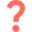
Проанализируйте результаты и сделайте выводы.

*# WRITE YOUR ANSWER*